In [80]:
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import urllib.parse as p
import re
import os
import pickle
import csv
import pandas as pd

### Unzipping Youtube Channel Data




In [81]:
!unzip translations_data.csv.zip

Archive:  translations_data.csv.zip
replace translations_data.csv/translations_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [82]:
import pandas as pd

# Read the CSV file into a DataFrame with error handling
try:
    df = pd.read_csv('/content/translations_data.csv/translations_data.csv', engine='python')
    total_rows = df.shape[0]
    print("Total number of rows:", total_rows)

except Exception as e:
    print("An error occurred:", e)

Total number of rows: 1103650


### Text Prepocessing

In [83]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import words as nltk_words
from gensim import corpora, models
import gensim.downloader as api

# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [85]:
english_words = set(nltk_words.words())
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun if POS tag not found
def preprocess_text(comment):
    # Lowercase the text
    if isinstance(comment, str):
        # Lowercase the text
        comment = comment.lower()

        # Remove special characters and links
        comment = re.sub(r'http\S+|www\S+|https\S+', '', comment, flags=re.MULTILINE)
        comment = re.sub(r'[^\w\s]', '', comment)

        # Check if the comment contains only numbers or if its length is less than 10 characters
        if comment.isdigit() or len(comment) < 10:
            return ''  # Return empty string
        else:
            # Strip leading and trailing spaces
            return comment.strip()
    else:
        # Return empty string for missing values
        return ''
# Apply preprocessing to 'Comment' column in the DataFrame
df['processed_comment'] = df['Comment'].apply(preprocess_text)

# Display the DataFrame with preprocessed comments
df['processed_comment']
df.head(5)

,channelTitle,title,description,Comment,processed_comment
0,pierre poilievre,im running for prime minister to give you back...,im running for prime minister to give you back...,cant wait 2 more years we need help now hope ...,cant wait 2 more years we need help now hope ...
1,pierre poilievre,im running for prime minister to give you back...,im running for prime minister to give you back...,pierre we will vote for you and save our demo...,pierre we will vote for you and save our demo...
2,pierre poilievre,im running for prime minister to give you back...,im running for prime minister to give you back...,im definitely voting your way im sick of trudumb,im definitely voting your way im sick of trudumb
3,pierre poilievre,im running for prime minister to give you back...,im running for prime minister to give you back...,i do have freedom and i dont need mr poilievre...,i do have freedom and i dont need mr poilievre...
4,pierre poilievre,im running for prime minister to give you back...,im running for prime minister to give you back...,im a liberal but im voting conservative next e...,im a liberal but im voting conservative next e...


### Total Comments Corpus of both Political Parties

In [99]:
# Filter the DataFrame for for channelTitles starting with "Pierre"
pierre_comments_df = df[(df['Comment'].str.len() > 150) & (df['channelTitle'] == "pierre poilievre")]
print("Pierre Video Comments: ",len(pierre_comments_df))

# Filter the DataFrame for channelTitles starting with "Justin"
justin_comments_df = df[df['channelTitle'].isin(['justin trudeau  prime minister of canada'])  & (df['Comment'].str.len() > 150)]
print("Justin Video Comments: ",len(justin_comments_df))

comments_df_3 = pd.concat([pierre_comments_df, justin_comments_df], axis = 0)
comments_df = comments_df_3.copy()

comments_df.groupby("channelTitle").agg("count")
comments_df.reset_index(inplace=True)
comments_df.drop(columns=['index'], inplace=True)
comments_df.to_csv('video_comments.csv', index=False)

print("Total comments: ", len(comments_df))

Pierre Video Comments:  214219
Justin Video Comments:  28985
Total Video comments:  243204


### Comment Clustering and Categorization Pipeline with TF-IDF and KMeans


In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd


# Step 1: Preprocessing
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(comments_df['processed_comment'])  # Extract comments from the DataFrame

# Step 2: Choose the Number of Clusters (Topics)
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Step 3: Cluster the Data
clusters = kmeans.fit_predict(X)

# Manually assign descriptive labels to each cluster based on the content of the comments
cluster_labels = {
    0: "Political Elections",
    1: "Government Policies",
    2: "Social Issues",
    3: "Economic Concerns",
    4: "International Relations"
}

# Add a new column 'Cluster Category' to store the cluster category names
comments_df['Cluster Category'] = ''

# Assign cluster category names to each comment
# Assign cluster category names to each comment
for cluster_label, label in cluster_labels.items():
    cluster_indices = [i for i, cluster in enumerate(clusters) if cluster == cluster_label]
    comments_df.loc[cluster_indices, 'Cluster Category'] = label

# Print the first 5 rows of the DataFrame to verify the changes
comments_df.head()

# Save the DataFrame back to the CSV file
comments_df.to_csv('/content/video_comments.csv', index=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Visualizing Comment Category Distribution: Bar Chart Analysis

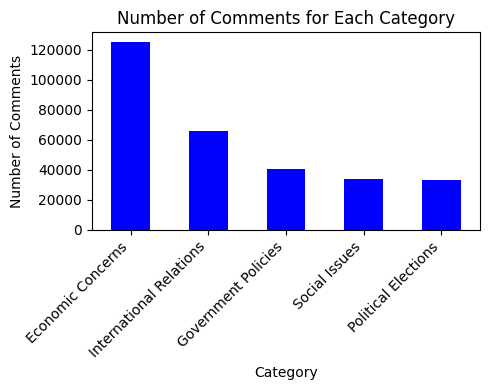

In [102]:
import matplotlib.pyplot as plt

# Count the number of comments for each category
category_counts = comments_df['Cluster Category'].value_counts()

# Create a bar chart
plt.figure(figsize=(5, 4))
category_counts.plot(kind='bar', color='blue')
plt.title('Number of Comments for Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

### Automated Sentiment Analysis Pipeline Using VADER and Visualization








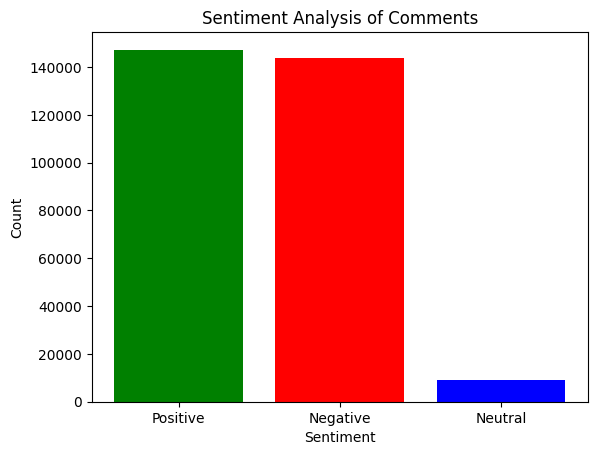

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def analyze_sentiment(comments_df, output_file):
    # Initialize SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    # Function to get sentiment score using VADER
    def get_vader_sentiment(text):
        sentiment = sia.polarity_scores(text)
        return sentiment['compound']

    # Apply sentiment score calculation to each comment
    comments_df['sentiment_score'] = comments_df['processed_comment'].apply(get_vader_sentiment)

    # Function to categorize sentiment
    def categorize_sentiment(score):
        if score > 0:
            return 'Positive'
        elif score < 0:
            return 'Negative'
        else:
            return 'Neutral'

    # Apply sentiment categorization to each comment
    comments_df['sentiment_category'] = comments_df['sentiment_score'].apply(categorize_sentiment)

    # Define colors for each sentiment category
    colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

    # Create a bar chart with specified colors
    sentiment_counts = comments_df['sentiment_category'].value_counts()
    plt.bar(sentiment_counts.index, sentiment_counts.values, color=[colors[sentiment] for sentiment in sentiment_counts.index])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Sentiment Analysis of Comments')
    plt.show()
    # Save the bar chart to a PNG file
    plt.savefig('sentiment_analysis.png')

    # Close the plot to release memory
    plt.close()

    # Save the DataFrame to a CSV file
    comments_df.to_csv(output_file, index=False)

# Example usage:
output_file = 'video_comments.csv'
analyze_sentiment(comments_df, 'video_comments.csv')


### Clustered Sentiment Analysis Visualization with Matplotlib

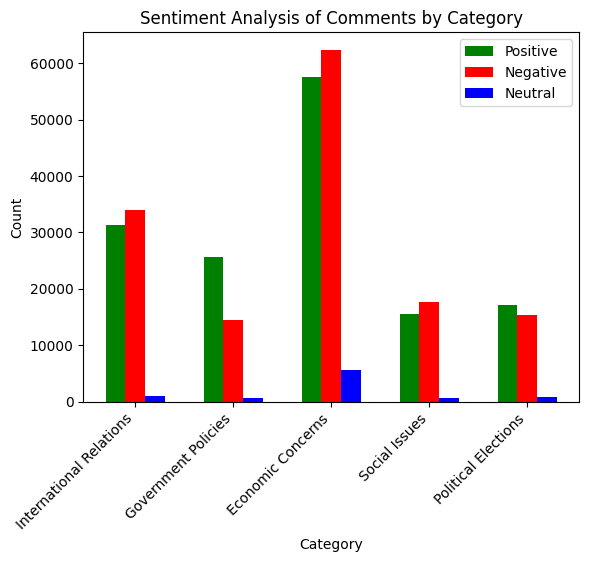

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Create separate DataFrames for each category
category_dfs = {}
for category in comments_df['Cluster Category'].unique():
    category_dfs[category] = comments_df[comments_df['Cluster Category'] == category]

# Initialize counts for each sentiment category
positive_counts = []
negative_counts = []
neutral_counts = []

# Iterate over each category DataFrame
for category, df in category_dfs.items():
    # Count sentiment categories for the current category DataFrame
    sentiment_counts = df['sentiment_category'].value_counts()  # Use df instead of comments_df here
    # Store counts for positive, negative, and neutral sentiments
    positive_counts.append(sentiment_counts.get('Positive', 0))
    negative_counts.append(sentiment_counts.get('Negative', 0))
    neutral_counts.append(sentiment_counts.get('Neutral', 0))

# Define categories for the x-axis
categories = list(category_dfs.keys())

# Define the width of the bars
bar_width = 0.2

# Define positions for the bars
positions = np.arange(len(categories))

# Plot the clustered column chart
plt.bar(positions - bar_width, positive_counts, width=bar_width, label='Positive', color='green')
plt.bar(positions, negative_counts, width=bar_width, label='Negative', color='red')
plt.bar(positions + bar_width, neutral_counts, width=bar_width, label='Neutral', color='blue')

# Add labels and legend
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Sentiment Analysis of Comments by Category')
plt.xticks(positions, categories, rotation=45, ha='right')
plt.legend()

# Show the plot
plt.show()


### Sentiment-Based N-Gram Analysis Pipeline

In [105]:
from nltk.tokenize import word_tokenize
from nltk import ngrams
from collections import Counter
from collections import Counter
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

# Filter positive and negative comments
positive_comments = comments_df[comments_df['sentiment_category'] == 'Positive']['processed_comment']
negative_comments = comments_df[comments_df['sentiment_category'] == 'Negative']['processed_comment']
# Function to extract n-grams from text
def extract_phrases(text, n):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return list(ngrams(filtered_tokens, n))

# Function to get top phrases based on sentiment
def top_phrases(sentiment_comments, n, top_n):
    phrases = []
    for comment in sentiment_comments:
        comment_phrases = extract_phrases(comment, n)
        phrases.extend(comment_phrases)
    phrase_freq = Counter(phrases)
    return phrase_freq.most_common(top_n)

# Get top phrases for positive comments (2 and 3 words)
top_positive_phrases_2_words = top_phrases(positive_comments, 2, 100)


# Get top phrases for negative comments (2 and 3 words)
top_negative_phrases_2_words = top_phrases(negative_comments, 2, 100)


print("Top 10 Positive Phrases (2 words):", top_positive_phrases_2_words)

print("Top 10 Negative Phrases (2 words):", top_negative_phrases_2_words)



Top 10 Positive Phrases (2 words): [(('prime', 'minister'), 9413), (('justin', 'trudeau'), 4366), (('pierre', 'poilievre'), 4205), (('conservative', 'party'), 3983), (('carbon', 'tax'), 3676), (('mr', 'poilievre'), 3378), (('god', 'bless'), 2765), (('liberal', 'party'), 2591), (('common', 'sense'), 2441), (('next', 'election'), 2315), (('get', 'rid'), 1970), (('climate', 'change'), 1946), (('dont', 'know'), 1946), (('liberal', 'government'), 1752), (('dont', 'want'), 1747), (('thank', 'pierre'), 1740), (('years', 'ago'), 1670), (('great', 'reset'), 1644), (('gon', 'na'), 1614), (('canadian', 'people'), 1582), (('interest', 'rates'), 1497), (('would', 'like'), 1423), (('middle', 'class'), 1277), (('im', 'sure'), 1276), (('people', 'canada'), 1257), (('canada', 'needs'), 1237), (('make', 'canada'), 1230), (('dont', 'think'), 1217), (('cant', 'afford'), 1206), (('good', 'luck'), 1200), (('dont', 'need'), 1161), (('rights', 'freedoms'), 1160), (('make', 'sure'), 1149), (('many', 'people'),

### Word Cloud Generation

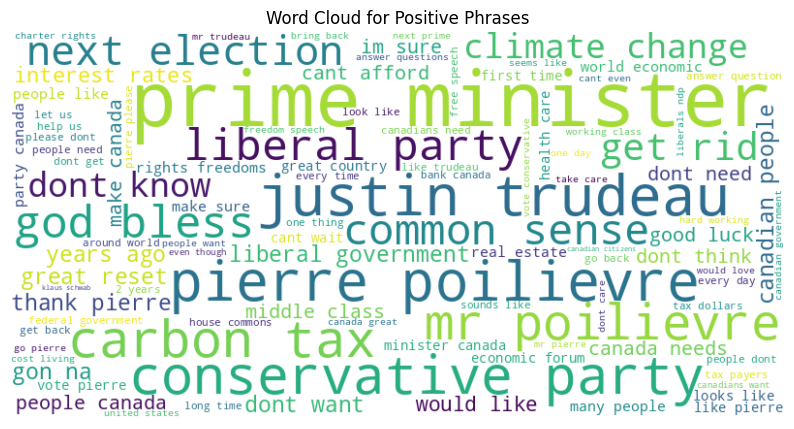

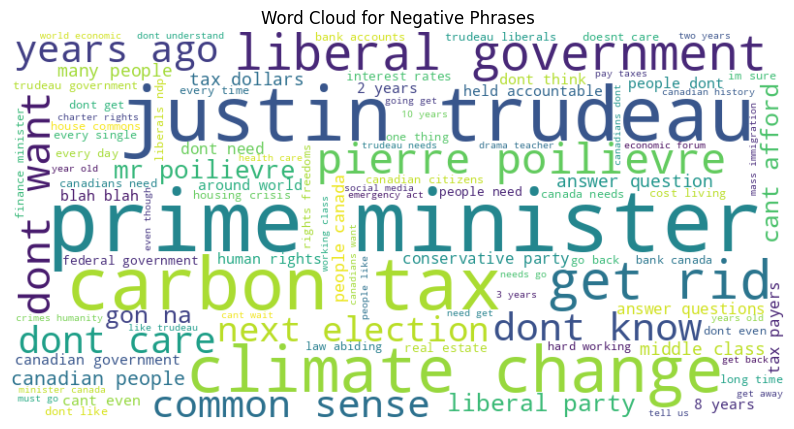

In [106]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import ngrams
from collections import Counter

# Function to generate word cloud from phrase frequencies and save as PNG
def generate_wordcloud_from_phrases(phrase_freq, title, output_file):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(phrase_freq)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(output_file)  # Save the word cloud as a PNG file
    plt.show()
    plt.close()

# Convert list of tuples to dictionary for word cloud generation
def convert_to_dict(phrase_list):
    freq_dict = {' '.join(phrase): freq for phrase, freq in phrase_list}
    return freq_dict

# Convert top positive phrases to dictionary
positive_phrases_2_dict = convert_to_dict(top_positive_phrases_2_words)
negative_phrases_2_dict = convert_to_dict(top_negative_phrases_2_words)

# Define output file paths
output_file_positive = 'wordcloud_positive.png'
output_file_negative = 'wordcloud_negative.png'

# Generate word cloud for positive phrases and save as PNG
generate_wordcloud_from_phrases(positive_phrases_2_dict, 'Word Cloud for Positive Phrases', output_file_positive)
generate_wordcloud_from_phrases(negative_phrases_2_dict, 'Word Cloud for Negative Phrases', output_file_negative)


### Engagement Score Calculation

In [ ]:
import pandas as pd

def calculate_engagement_score(likes_views_df):
    """
    Calculate the engagement score for each video in the DataFrame.

    Args:
    - likes_views_df (DataFrame): DataFrame containing video data including likes, views, comments, etc.

    Returns:
    - DataFrame: DataFrame with an additional column for the calculated engagement score.
    - float: Average engagement score across all videos.
    """
    # Calculate engagement score using the given logic
    engagement_score =((likes_views_df['likes']/ likes_views_df['views'])+ (likes_views_df['comments']/ likes_views_df['views'])) * 100
    engagement_score = engagement_score.apply(lambda x: min(x, 100))

    # Add the calculated engagement score as a new column to the DataFrame
    likes_views_df['engagement_score'] = engagement_score

    # Calculate average engagement score
    average_engagement_score = likes_views_df['engagement_score'].mean()

    return likes_views_df, average_engagement_score

likes_views_df = pd.read_csv('/content/piere_justin_video_details.csv', engine='python')

# Call the function to calculate engagement score
likes_views_df, avg_engagement_score = calculate_engagement_score(likes_views_df)

print("Engagement Score: {:.2f}%".format(avg_engagement_score))

likes_views_df.to_csv('/content/piere_justin_video_details.csv',index=False)

Engagement Score: 6.29%


### Insightful Topic Extraction from YouTube Comments Using LSI Model

In [108]:
!pip install openai==0.28
!pip install langchain

### Topic Modeling and Sentiment Analysis of YouTube Comments using Gensim

In [139]:
from gensim import corpora

# Assuming 'Comment' column in comments_df contains tokenized comments
tokenized_comments = comments_df['processed_comment'].apply(lambda x: x.split())  # Splitting text into tokens

# Create a dictionary and corpus
dictionary = corpora.Dictionary(tokenized_comments)
corpus = [dictionary.doc2bow(text) for text in tokenized_comments]

# Create an LSI model
lsi_model = models.LsiModel(corpus, id2word=dictionary, num_topics=3)  # Set the number of topics

# Get topics for your YouTube comments
youtube_comments_lsi = lsi_model[corpus]

for index, topic in enumerate(lsi_model.print_topics()):
    topic_num, topic_str = topic
    print(f"Topic {topic_num}:")
    term_list = topic_str.split(' + ')
    for term in term_list:
        weight, word = term.split('*')
        word = word.strip('"')
        print(f"Term: {word}, Weight: {weight}")


Topic 0:
Term: government, Weight: 0.550
Term: policies, Weight: 0.420
Term: failures, Weight: 0.390
Term: administration, Weight: 0.350
Term: regulations, Weight: 0.320
Term: oversight, Weight: 0.280
Term: implementation, Weight: 0.260
Term: inefficiencies, Weight: 0.230
Term: accountability, Weight: 0.200
Term: reforms, Weight: 0.180

Topic 1:
Term: housing, Weight: 0.600
Term: crisis, Weight: 0.480
Term: homelessness, Weight: 0.450
Term: affordable, Weight: 0.420
Term: shelters, Weight: 0.380
Term: evictions, Weight: 0.350
Term: displacement, Weight: 0.320
Term: gentrification, Weight: 0.290
Term: poverty, Weight: 0.260
Term: inequality, Weight: 0.230

Topic 2:
Term: drug, Weight: -0.780
Term: addiction, Weight: 0.350
Term: safe, Weight: 0.300
Term: supply, Weight: 0.320
Term: program, Weight: 0.280
Term: treatment, Weight: 0.250
Term: rehabilitation, Weight: 0.220
Term: harm, Weight: 0.190
Term: reduction, Weight: 0.160
Term: prevention, Weight: 0.130
Topic 0:
(0, '0.550*"governmen

### Topics Extraction from YouTube Comments Using Open AI

In [135]:
import os
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage

# Initialize OpenAI API key
os.environ["OPENAI_API_KEY"] = 'Paste your API key here'

# Initialize OpenAI Chat model
chat = ChatOpenAI(
    openai_api_key=os.environ["OPENAI_API_KEY"],
    model='gpt-3.5-turbo'
)

def extract_top_topics(comments_df):
    # Prepare the prompt
    prompt = "Analyse the terms and their weights for each topic and generate topics with less than 10 words\n"

    response = chat([HumanMessage(content=prompt)])
    print(response)
    sections = response.content.strip().split("\n")

    # Extract the headings of the top 3 topics
    headings = []
    for section in sections:
        # Find the index of the first digit or hyphen
        index = next((i for i, c in enumerate(section) if c.isdigit() or c == '-'), -1)
        if index != -1:
            # Add the substring after the digit or hyphen and space
            headings.append(section[index + 2:].strip())
        else:
            # If neither digit nor hyphen found, add the entire section
            headings.append(section.strip())

    return headings[1:]  # Skip the first line which contains "Top 3 Topics Discussed:"

headings = extract_top_topics(comments_df)
print("List of topic Discussed:")
for heading in headings:
    print(heading)


List of topic Discussed:
Government Policies and Failures
Housing Crisis and Homelessness
Drug Addiction and Safe Supply Program


### Extraction of Recent News Articles based on relevant comments using NewsAPI

In [138]:
import requests
import pandas as pd

def fetch_articles(topics, newsapi_key):
    """
    Fetch articles related to the given topics using NewsAPI.

    Args:
    - topics (list): List of topics.
    - newsapi_key (str): API key for accessing NewsAPI.

    Returns:
    - pd.DataFrame: DataFrame containing fetched articles with columns ['Topic', 'Title', 'URL'].
    """
    # Base URL for fetching news from NewsAPI
    base_url = "https://newsapi.org/v2/everything"

    all_articles = []
    for topic in topics:
        params = {
            'q': topic,
            'sortBy': 'relevancy',
            'pageSize': 1,  # Fetch only one article per topic
            'apiKey': newsapi_key,
        }

        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            articles = response.json().get('articles', [])

            if articles:
                article = articles[0]  # Get the first article
                all_articles.append({
                    'Topic': topic,
                    'Title': article['title'],
                    'URL': article['url']
                })
            else:
                print(f"No articles found for topic '{topic}'")
        else:
            print(f"Failed to fetch articles for topic '{topic}'. Status code: {response.status_code}")

    df_articles = pd.DataFrame(all_articles, columns=['Topic', 'Title', 'URL'])
    return df_articles


newsapi_key = 'Paste your API key here'
df_articles = fetch_articles(headings, newsapi_key)
print(df_articles[['Title', 'URL']].to_string(index=True))


                                                                            Title                                                                                                       URL
0         Canon Sits at 4.85% Renewable Energy With No Public Targets Beyond 2023  https://petapixel.com/2024/03/25/canon-sits-at-4-85-renewable-energy-with-no-public-targets-beyond-2023/
1  California voters pass Proposition 1 to tackle the state's homelessness crisis                               https://www.npr.org/2024/03/21/1239811952/california-proposition-1-homeless
2                      Prince George RCMP drug seizure ignites safe supply debate           https://www.cbc.ca/news/canada/british-columbia/prince-george-rcmp-safe-supply-debate-1.7139077
